In [2]:
from pathinit import *

import numpy as np

import jax
import jax.numpy as jnp

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

jax.config.update("jax_enable_x64", True)
from functools import partial

import matplotlib as mpl
from matplotlib import pyplot as plt

# Thème: se passer de boucle for/while ...

# Les fractales de Julia

$$
\Large
\begin{cases}
x_0 = x_{pixel} \quad y_0=y_{pixel} \\
x_{n+1} = x_n^2 - y_n^2 + c_x \\
y_{n+1} = 2 x_n y_n + c_y
\end{cases}
$$
Dés que $(x_n,y_n)$ sort du disque de centre $(0,0)$ et de rayon $2$ on arrête la récursion, ainsi que si $n$ atteint une valeur maximale arbitraire signifiant alors que le pixel $(x_0,y_0)$ appartient à la fractale de Julia. Suivant le couple $(c_x,c_y)$ on obtient des fratales différents.

# Une implémentation simple en Numpy

In [7]:
XMIN, XMAX, YMIN, YMAX = -1.25, 1.25, -1.25, 1.25   # le cadre physique
LARGEUR, HAUTEUR = 512, 512                         # nmbre de pixels 512x512
MAX_ITERATION = 150  # un paramètre de l'algo

In [8]:
cx, cy = 0.285, 0.01

In [9]:
# l'image finale
Pixels = np.zeros(shape=(LARGEUR, HAUTEUR))

In [10]:
for iy in range(HAUTEUR):
    for ix in range(LARGEUR):
        xn = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        yn = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)
        n = 0
        while (xn * xn + yn * yn) < 4 and n < MAX_ITERATION:
            tmp_x = xn
            tmp_y = yn
            xn = tmp_x * tmp_x - tmp_y * tmp_y + cx
            yn = 2 * tmp_x * tmp_y + cy
            n = n + 1
        if n == MAX_ITERATION:
            Pixels[ix,iy]=0
        else:
            R = (3.*n)/256
            G = (1.*n)/256
            B = (10.*n)/256
            Pixels[ix,iy]=0.222*R + 0.666*G + 0.111*B

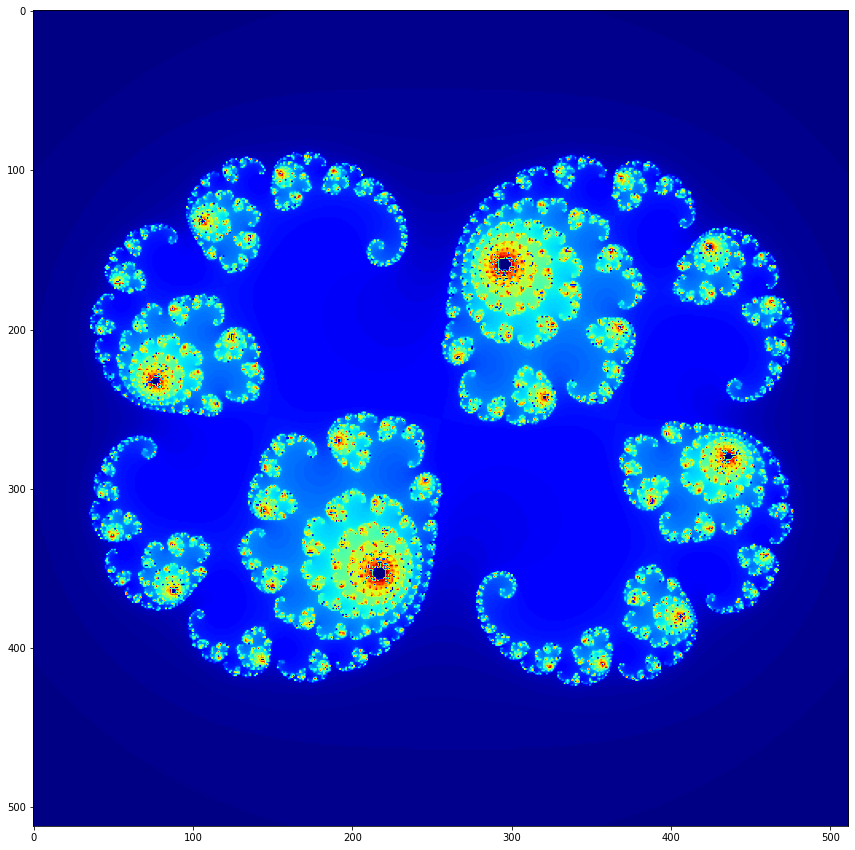

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(Pixels,cmap=mpl.cm.jet)

# Une implémentation JAX

# usage de [jax.lax.cond](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html?highlight=jax.lax.cond#jax.lax.cond)

In [12]:
def f(x,y):
    return jax.lax.cond(x>1,lambda p: p, lambda p: p**2,operand=y)

In [13]:
vf = jax.vmap(jax.vmap(f, in_axes=(None, 0)), in_axes=(0, None))

In [14]:
vf(jnp.array([1,2]),jnp.array([0.,2.,3.]))

DeviceArray([[0., 4., 9.],
             [0., 2., 3.]], dtype=float64)

## Pour implémenter le code pour la fractale de Julia on utilise

```python
jax.lax.while_loop(cond_fun, body_fun, init_val) 
```
## qui est equivalent à 

```python
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```

In [15]:
def julia(args_vars):
    
    cx,cy, XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION = args_vars
     
    def func(ix,iy):
    
        def body(val):
            n = val[0]
            x = val[1]
            y = val[2]
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        x0 = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        y0 = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)

        u = (0,x0,y0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]
        
        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION), 
                                 lambda _: 0., 
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)

        
        return pixel_val
        
    mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    return result

In [17]:
args = (cx,cy, XMIN, XMAX, YMIN, YMAX, 1024, 1024, 150)
tmp = julia(args)

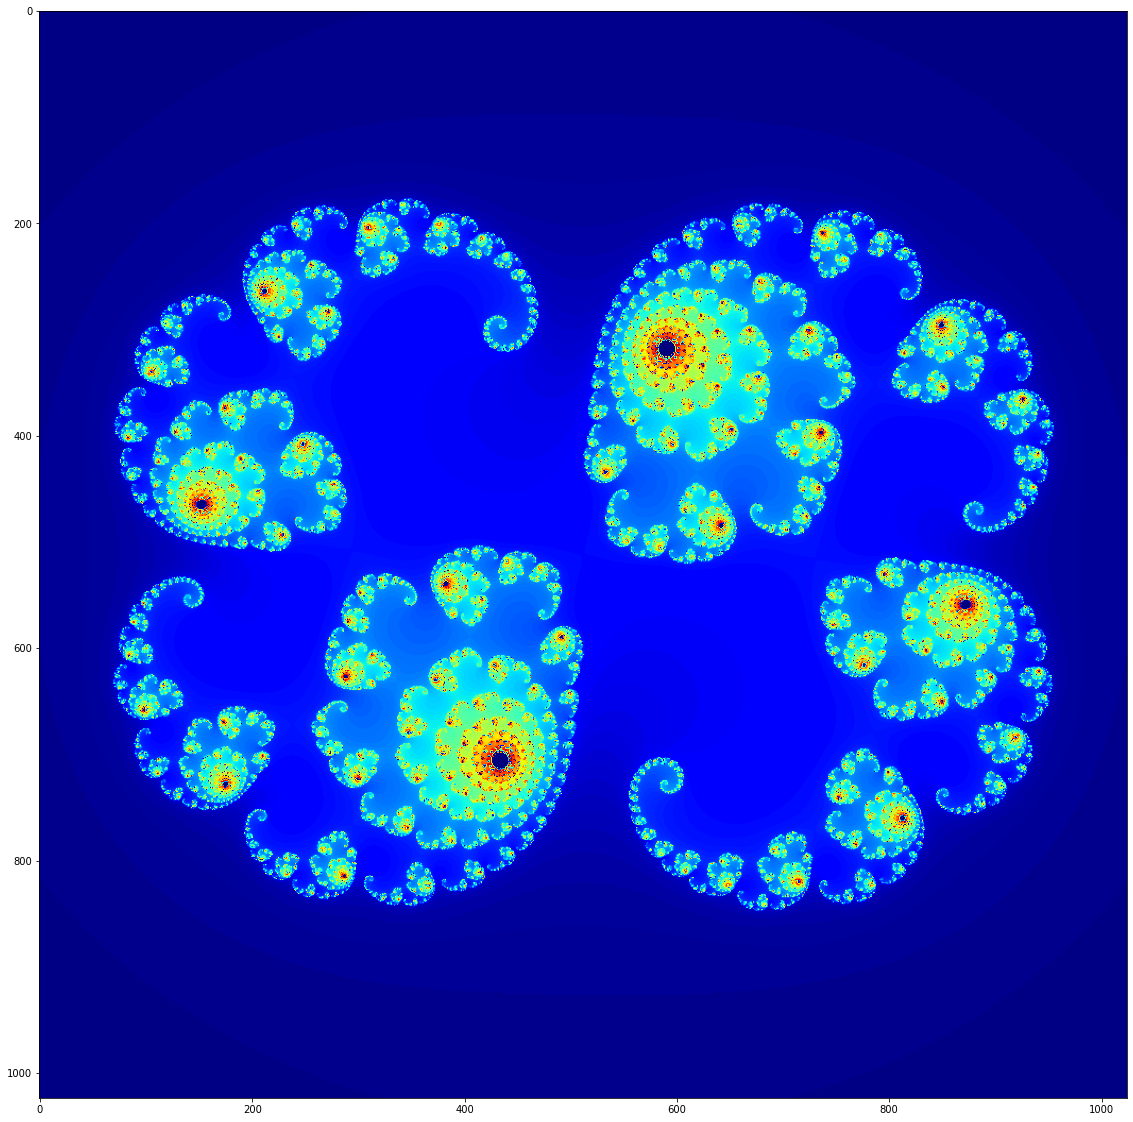

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(tmp,cmap=mpl.cm.jet)

In [27]:
args = (0.3,0.015, XMIN, XMAX, YMIN, YMAX, 4096, 4096, 150)
tmp = julia(args)

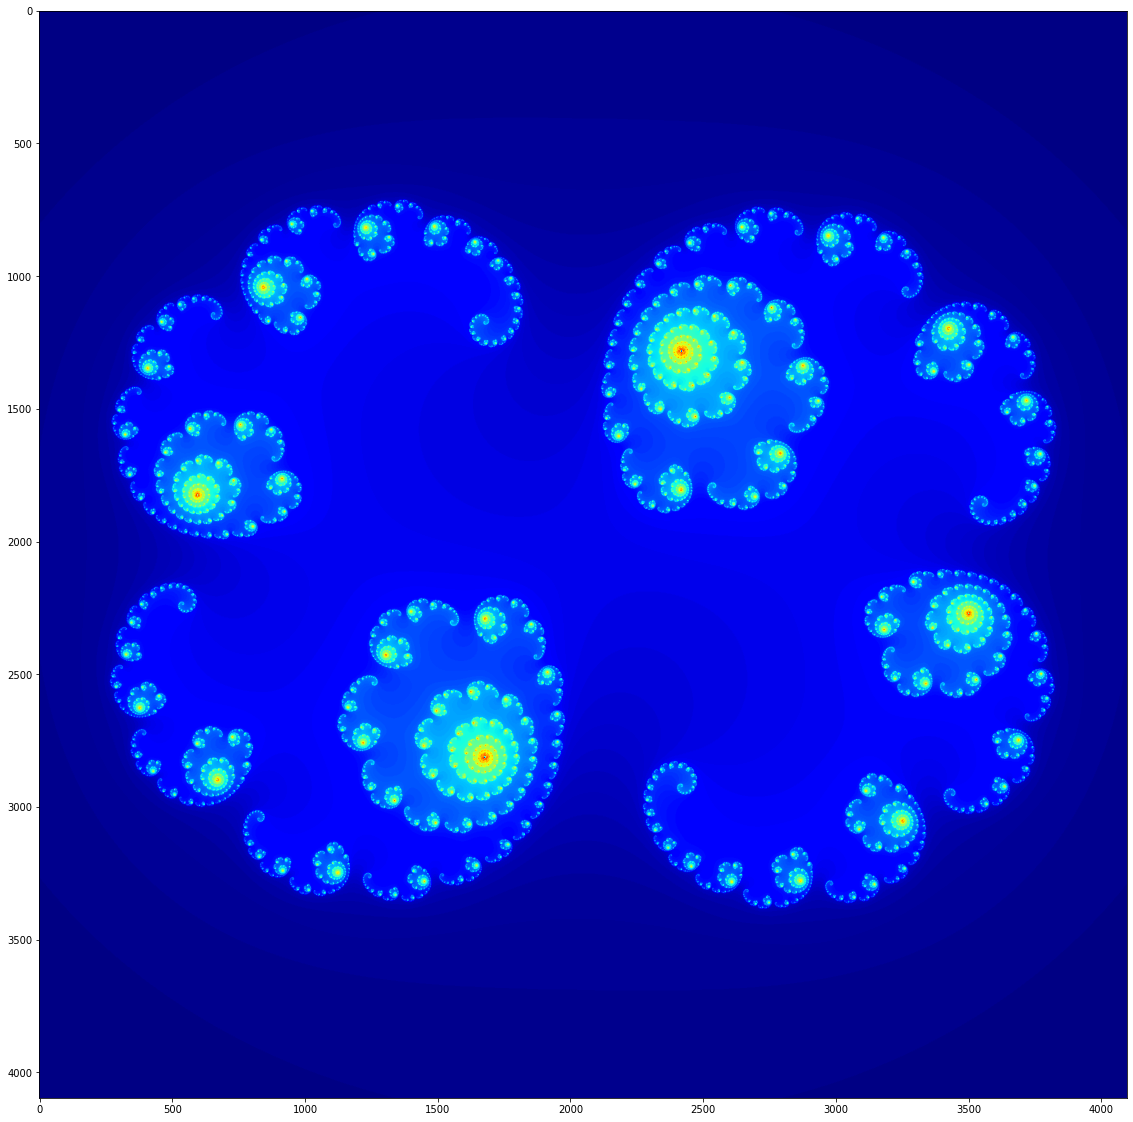

In [28]:
plt.figure(figsize=(20,20))
plt.imshow(tmp,cmap=mpl.cm.jet)

## Faites joujou avec les valeurs de $c_x, c_y$ 

Pour aller plus loin:
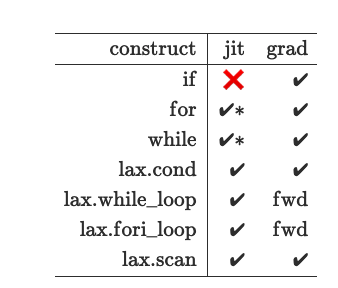

https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html?highlight=control_flow#control-flow

# Exercice 1) :
Implémeter le système suivant qui est très proche des fractales de Julia
$$
(XMIN, XMAX, YMIN, YMAX) = (-2, +0.5, -1.25, +1.25) \\
MAX\_ITERATION = 150
$$
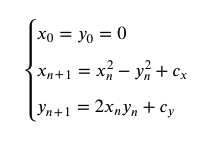

Cette fois-ci on teste si (c_x, c_y) appartient à l'ensemble ou pas avec le même test que pour Julia (cf. `cond_fun` est inchangée)

hint: cette fois-ci `u=(0,0,0)`,  et `(c_x, c_y)` doit définit avant la boucle while...

In [40]:
def mandelbrot(args_vars):
    
    XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION = args_vars
        
    def func(ix,iy):
    
        cx = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        cy = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)

        def body(val):
            n = val[0]
            x = val[1]
            y = val[2]
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        u = (0,0,0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]
        
        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION), 
                                 lambda _: 0., 
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)

        
        return pixel_val
        
    mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    return result

In [41]:
XMIN, XMAX, YMIN, YMAX = -2, +0.5, -1.25, +1.25
args = (XMIN, XMAX, YMIN, YMAX, 1024, 1024, 150)
tmp = mandelbrot(args)

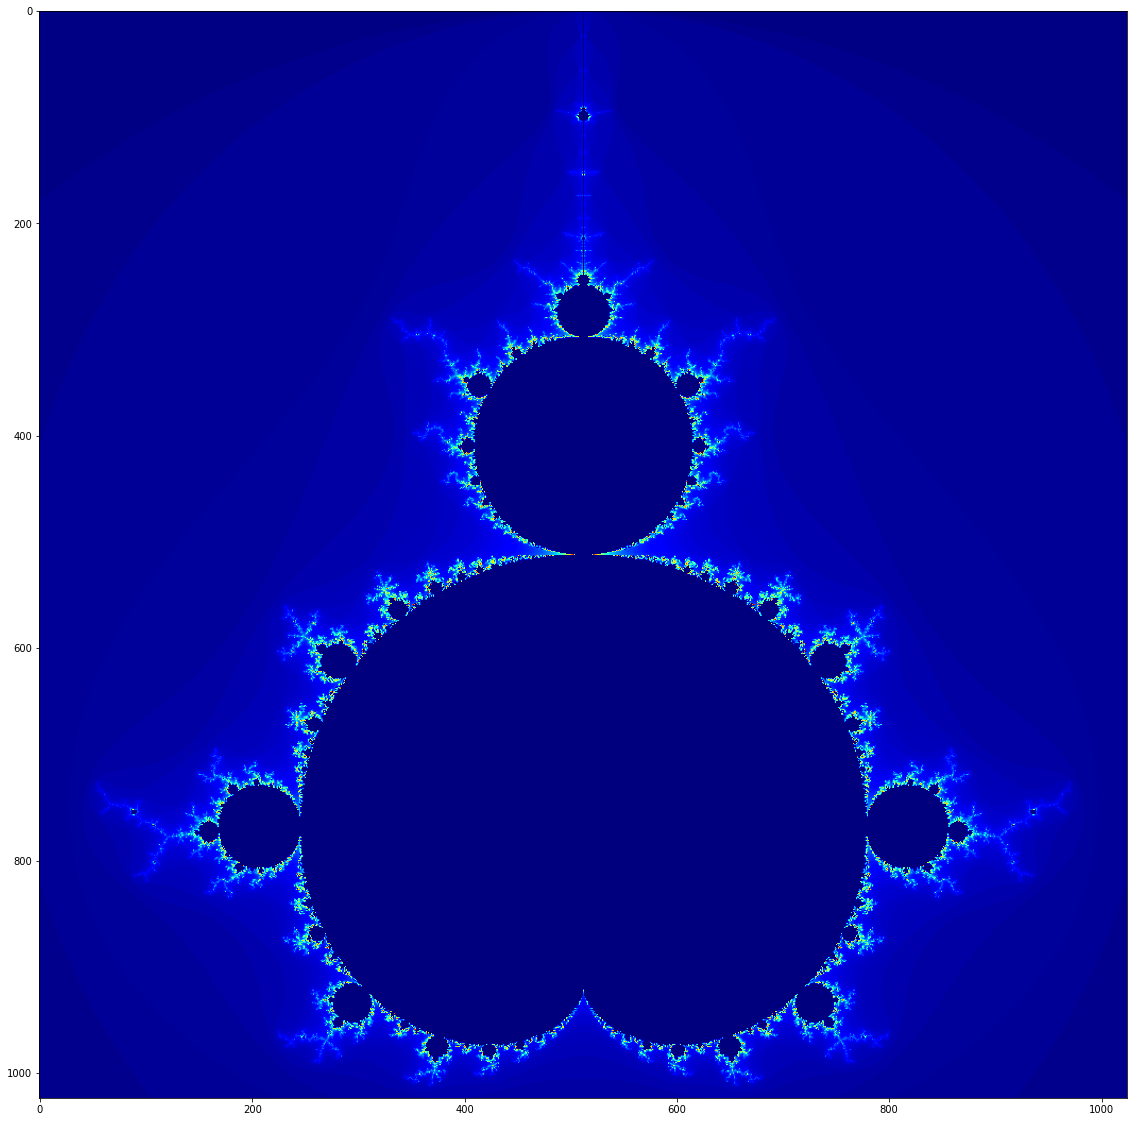

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(tmp,cmap=mpl.cm.jet)

# Exercice 2)
A la fin du notebook `JAX-first-grad-vmap.ipynb`: Réécrire la fonction `minimize` (notée `minimize_bis`) en utilisant le pattern `cond_fun/body/jax.lax.while_loop`


# On peut passer en GPU juste pour voir...

# Takeaway message:
- comment utiliser les fonctions `jax.lax.cond`, `jax.lax.while` ...
- sans changement le code fonctionne (en principe) sous GPU